Data Source - https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

Papers:
1. https://arxiv.org/abs/2003.05681

In [1]:
import sys
sys.path.append('/Users/manishrai/venv_ml/lib/python3.7/site-packages/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.optimize import curve_fit
from scipy.stats import pearsonr # get the pearson correaltion

In [2]:
df = pd.read_excel('/Users/manishrai/Desktop/COVID-19/data/COVID-19-geographic-disbtribution-worldwide-2020-03-22.xlsx')
df.head(4)

,DateRep,Day,Month,Year,Cases,Deaths,Countries and territories,GeoId
0,2020-03-22,22,3,2020,0,0,Afghanistan,AF
1,2020-03-21,21,3,2020,2,0,Afghanistan,AF
2,2020-03-20,20,3,2020,0,0,Afghanistan,AF
3,2020-03-19,19,3,2020,0,0,Afghanistan,AF


In [3]:
print("Data range of available data:", min(df.DateRep), max(df.DateRep))

Data range of available data: 2019-12-31 00:00:00 2020-03-22 00:00:00


In [4]:
df_by_country = df.groupby(['Countries and territories'])['Cases', 'Deaths'].sum().reset_index()
df_by_country.sort_values(by=['Cases', 'Deaths'], inplace=True, ascending=False)
df_by_country['fatality_pct'] = np.round(100*df_by_country.Deaths/df_by_country.Cases, 2)
df_by_country.head(n=4)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Countries and territories,Cases,Deaths,fatality_pct
36,China,81499,3267,4.01
87,Italy,53578,4827,9.01
173,United_States_of_America,26747,340,1.27
155,Spain,24926,1326,5.32


In [5]:
df_by_country.to_csv('df_by_country.csv', index=False)

In [6]:
top10_country_list = list(set(df_by_country.iloc[0:9,]['Countries and territories']))

In [7]:
df_by_country_date = df.groupby(['Countries and territories', 'DateRep'])['Cases', 'Deaths'].sum().reset_index()
df_by_country_date.head(n=4)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Countries and territories,DateRep,Cases,Deaths
0,Afghanistan,2019-12-31,0,0
1,Afghanistan,2020-01-01,0,0
2,Afghanistan,2020-01-02,0,0
3,Afghanistan,2020-01-03,0,0


In [10]:
def fit_exponential_curve(x, a, b):
    """Function to fit an exponential growth curve"""
    # a*math.exp(x*b)
    return np.power(a*b, x)

def richard(time, alpha, beta, rate, slope):
    """
    Computes the Richard growth model
    Parameters
    ----------
    time : time
    alpha : upper asymptote
    beta : growth range
    rate : growth rate
    slope : slope of growth
    See Also
    --------
    richard_inverse
    References
    ----------
    .. [1] D. Fekedulegn, M. Mac Siurtain, and J. Colbert, "Parameter estimation
           of nonlinear growth models in forestry," Silva Fennica, vol. 33, no.
           4, pp. 327-336, 1999.
    """

    result = (1 + beta * np.exp(-rate * time))

    if result < 0 and slope > 1:
        result = float('nan')
    else:
        result = result ** (1 / slope)
        result = alpha / result

    return result


def generalised_richard(time, A, U, k, m, beta, t0=0):
    """
    Computes the Generalised Richard growth model
    Parameters
    ----------
    time : time
    A : the lower asymptote
    U : the upper asymptote
    k : growth range
    m : slope of growth
    beta : growth range
    t0 : time shift (default 0)
    See Also
    --------
    generalised_richard_inverse
    References
    ----------
    .. [1] D. Fekedulegn, M. Mac Siurtain, and J. Colbert, "Parameter estimation
           of nonlinear growth models in forestry," Silva Fennica, vol. 33, no.
           4, pp. 327-336, 1999.
    """

    result = A + richard(time - t0, U - A, beta, k, m)

    return result

In [11]:
generalised_richard(10, 0, 10000, 1.088, 1, 0.23)

9999.956688622959

In [12]:
def get_plot_dist_with_dual_axis(x, yl, yh, title):
    fig, ax1 = plt.subplots(figsize=(16, 4))
    ax1.plot(x, yh, color='#7f6d5f', label='Cases', alpha=0.75)
    ax1.set_ylabel('# of Cases')
    ax1.set_xlabel('Days since first case')
    ax1.set_xticklabels(x, rotation='vertical')
    ax1.xaxis.set_ticks(x)
    ax1.set_ylim([0, max(yh)*1.05])
    ax1.legend(loc=2)
    
    ax2 = ax1.twinx()
    ax2.plot(x, yl, color='r', label='Death', alpha=0.75)
    ax2.set_ylabel('# of Death')
    ax2.legend(loc=6)
    ax2.set_ylim([0, max(yl)*1.75])
    
    plt.title(title, fontsize=14)
    plt.grid()
    plt.show()

In [13]:
neighbors_list = ['India']

**Plot the cumulative distribution by country**

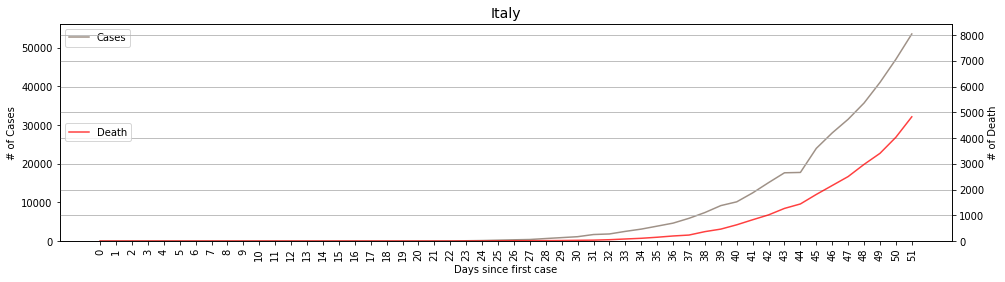

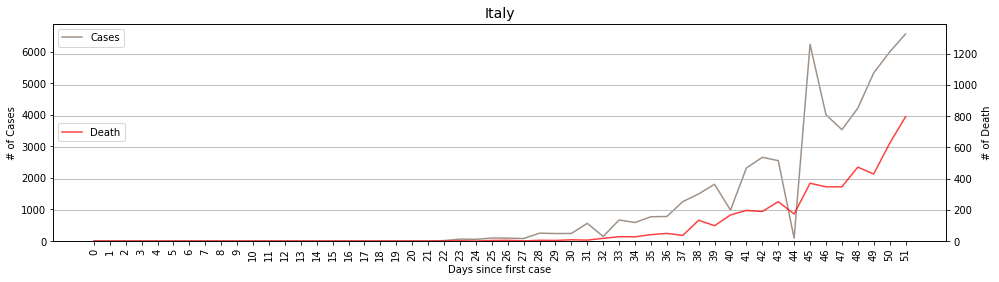

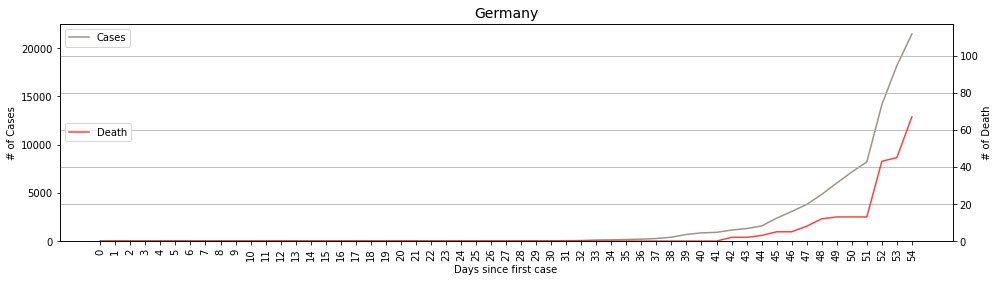

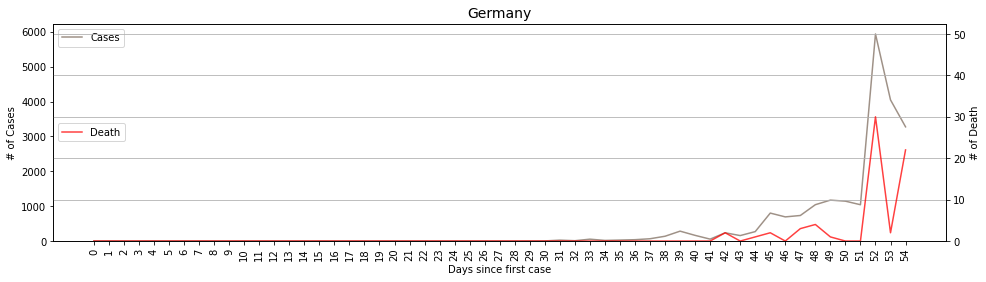

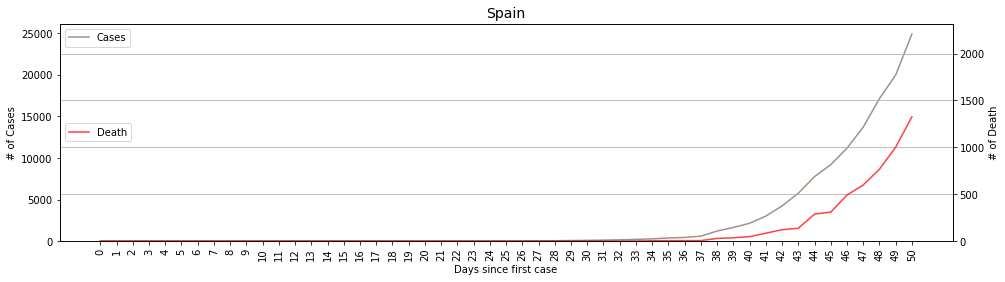

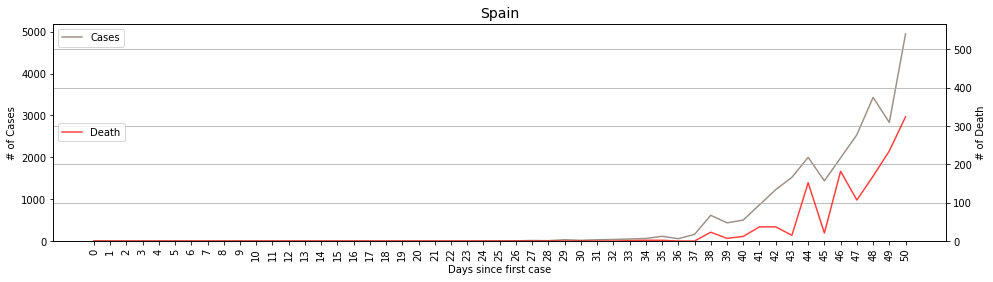

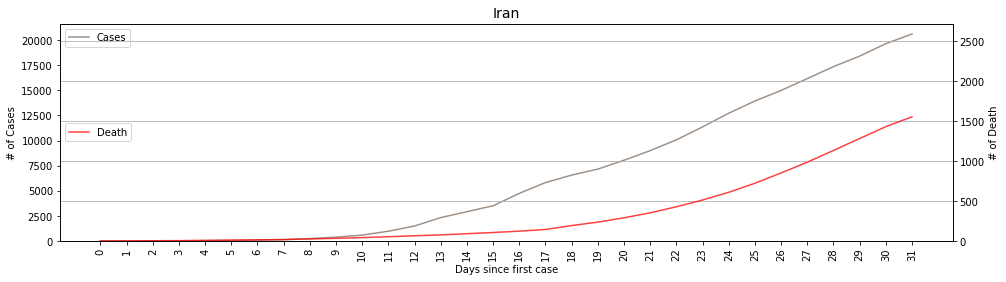

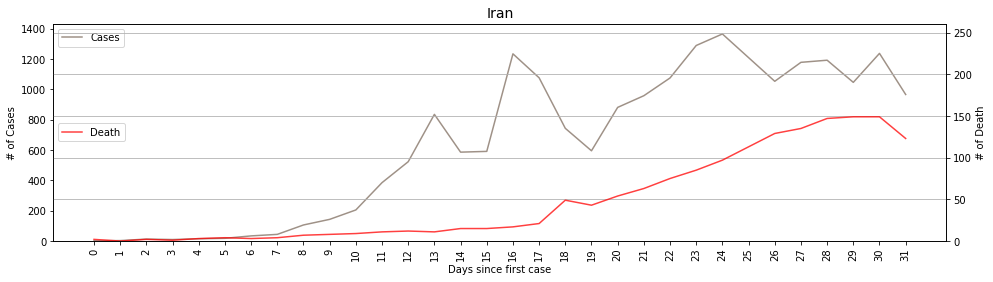

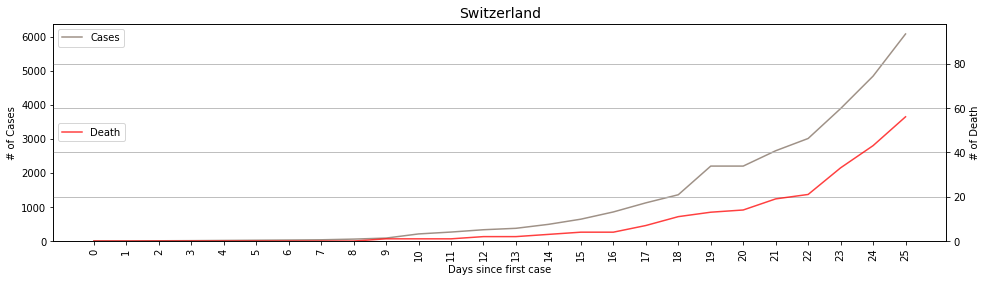

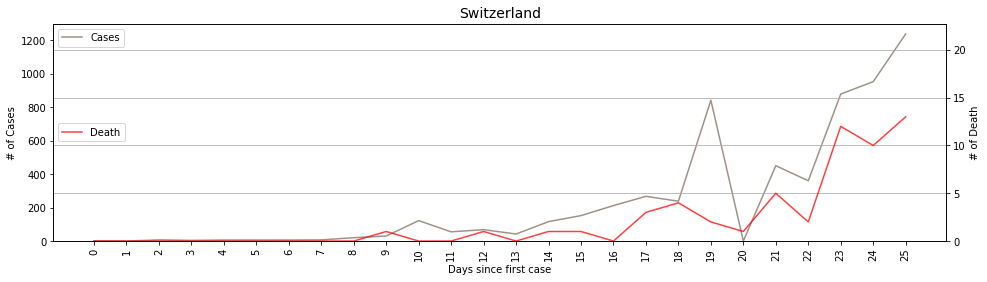

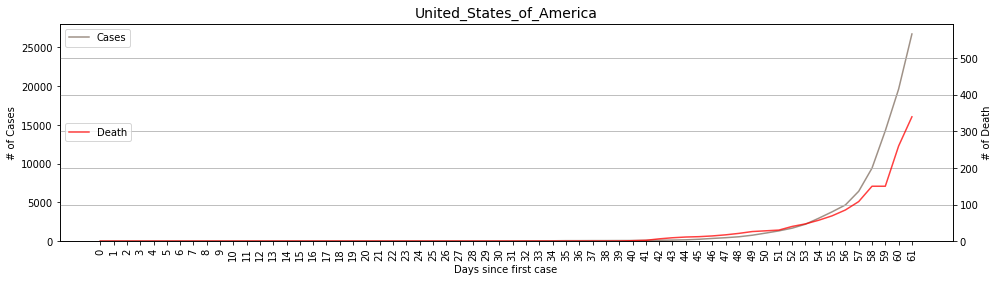

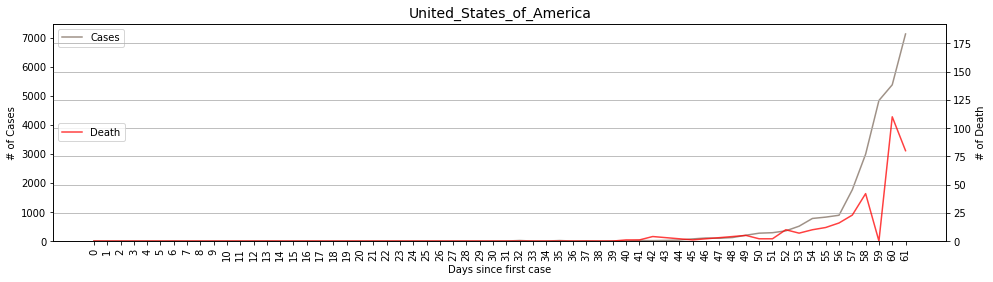

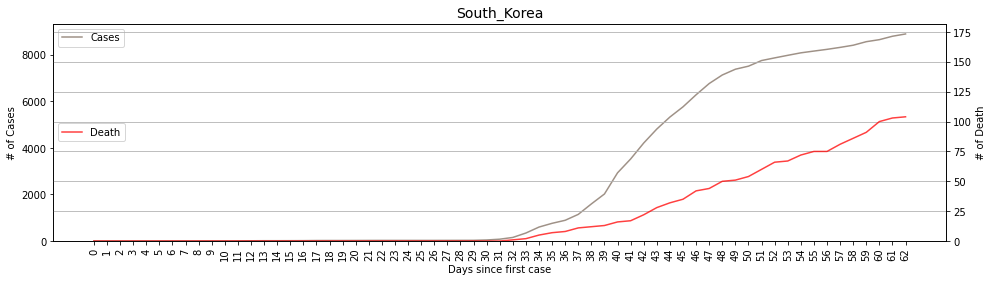

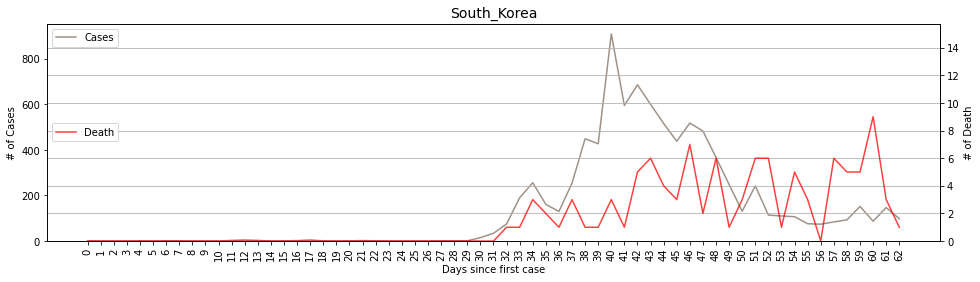

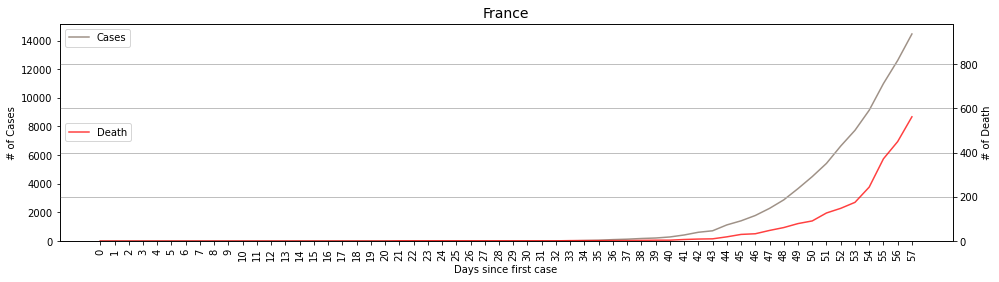

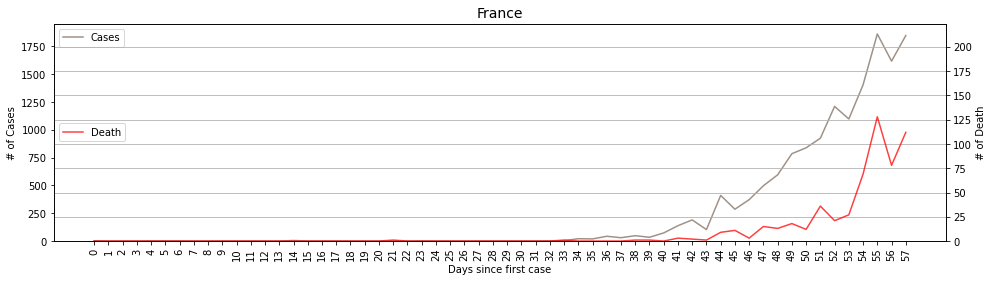

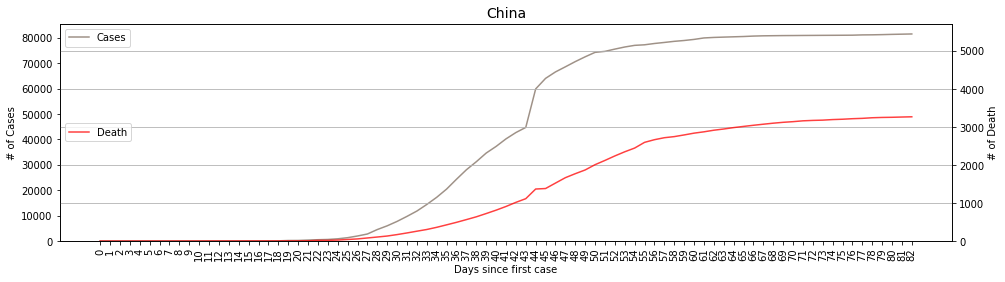

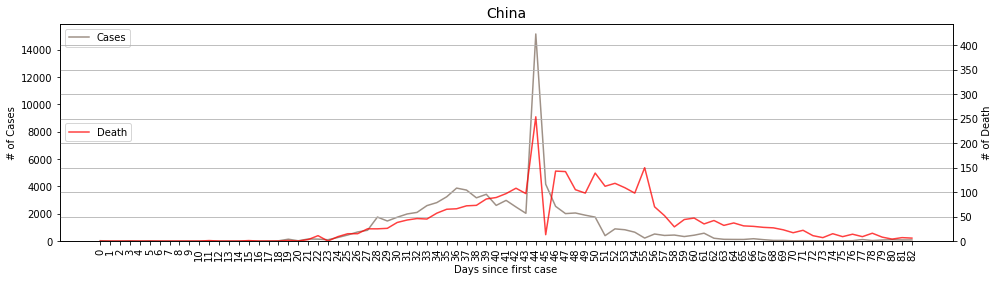

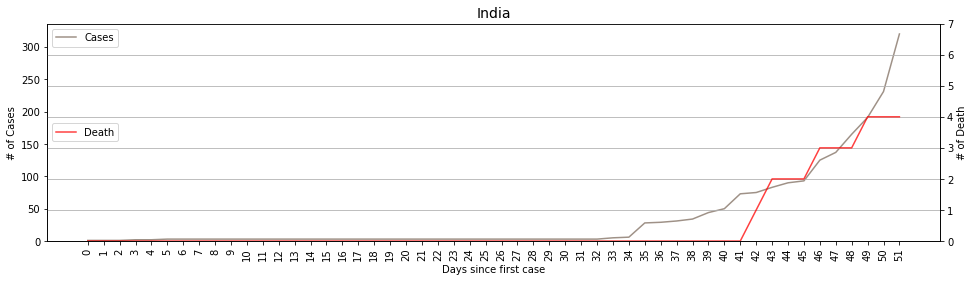

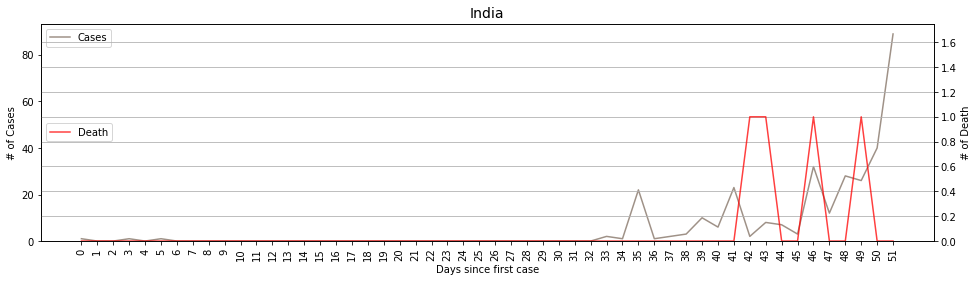

In [15]:
for country in top10_country_list + neighbors_list:
    df_temp = df_by_country_date[df_by_country_date['Countries and territories']==country]
    df_temp_dict = df_temp.to_dict(orient='records')
    x_dates, y_cases, y_deaths, y_cases_cum, y_deaths_cum = [], [], [], [], []
    
    i=0
    for record in df_temp_dict:
        x_dates.append(pd.to_datetime(record['DateRep']).strftime('%Y-%m-%d'))
        y_cases.append(record['Cases'])
        y_deaths.append(record['Deaths'])
        # cumuliative
        y_cases_cum.append(sum(y_cases))
        y_deaths_cum.append(sum(y_deaths))
        if sum(y_cases)==0:
            i = i+1 
        # plot 
    get_plot_dist_with_dual_axis(list(range(len(y_deaths_cum) - i)), 
                                            y_deaths_cum[i:], y_cases_cum[i:], country)
    
    get_plot_dist_with_dual_axis(list(range(len(y_deaths_cum) - i)), 
                                            y_deaths[i:], y_cases[i:], country)

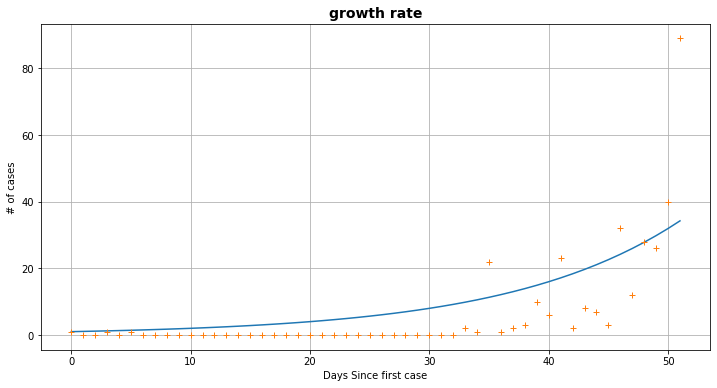

In [17]:
n = 70
x = list(range(len(y_deaths_cum) - i))
# x = list(range(n))
# y = y_cases_cum[i:]
y = y_cases[i:]# [:n]
param, param_cov = curve_fit(fit_exponential_curve, x, y)

plt.figure(figsize=(12, 6))
plt.plot(list(range(len(y))), [fit_exponential_curve(v, param[0], param[1]) for v in range(len(y))])
plt.plot(x, y, '+')
plt.xlabel('Days Since first case')
plt.ylabel('# of cases')
plt.title("growth rate", fontsize=14, fontweight='bold')
plt.grid()
plt.show()

In [18]:
df_population_density = pd.read_csv('/Users/manishrai/Desktop/COVID-19/data/country_wise_population_density.csv')
df_population_density.head(n=4)

,Country Name,Country Code,2018
0,Afghanistan,AFG,56.937760
1,Albania,ALB,104.612263
2,Algeria,DZA,17.730075
3,American Samoa,ASM,277.325000


In [19]:
df_by_country = pd.merge(left=df_by_country,
         right=df_population_density,
         left_on='Countries and territories', 
         right_on='Country Name',
         how='left'
        )
df_by_country.head(n=4)

,Countries and territories,Cases,Deaths,fatality_pct,Country Name,Country Code,2018
0,China,81499,3267,4.01,China,CHN,148.348833
1,Italy,53578,4827,9.01,Italy,ITA,205.450748
2,United_States_of_America,26747,340,1.27,United_States_of_America,USA,35.766089
3,Spain,24926,1326,5.32,Spain,ESP,93.529058


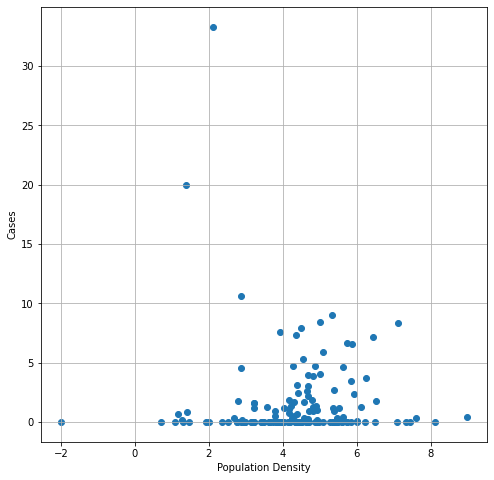

In [20]:
plt.figure(figsize=(8, 8))
df_by_country_temp = df_by_country.dropna()
x = np.log(list(df_by_country_temp.iloc[:, 6]))
y = list(df_by_country_temp.iloc[:, 3]) # cases

plt.scatter(x, y)
plt.xlabel('Population Density')
plt.ylabel('Cases')
# plt.xlim([0, 4000])
# plt.ylim([0, 15])
plt.grid()
plt.show()

In [21]:
print(np.cov(x, y))
print(pearsonr(x, y))

[[ 2.25752567 -0.32466298]
 [-0.32466298 14.00087961]]
(-0.05774824200238108, 0.48123756295223935)


No linear relationship between fatality and density